# Thermoelastic bilayer bending

- The bottom layer expands on heating
- The top layer does not expand on heating
- This is a plane strain simulation


# Units
- Length: mm
- Mass: kg
- Time: s
- Mass density: kg/mm^3
- Force: milliN
- Stress: kPa 
- Energy: microJ
- Temperature: K
- Boltzmann Constant: 1.38E-17 microJ/K
- Number of polymer chains per unit vol: #/mm^3
- Thermal expansion coefficient: #/K
- Specific heat: microJ/(mm^3 K)
- Thermal conductivity: microW/(mm K)

### Software:
- Dolfinx v0.8.0

In the collection "Example Codes for Coupled Theories in Solid Mechanics,"

By Eric M. Stewart, Shawn A. Chester, and Lallit Anand.

https://solidmechanicscoupledtheories.github.io/

# Import modules

In [25]:
# Import FEnicSx/dolfinx
import dolfinx

# For numerical arrays
import numpy as np

# For MPI-based parallelization
from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()

# PETSc solvers
from petsc4py import PETSc

# specific functions from dolfinx modules
from dolfinx import fem, mesh, io, plot, log
from dolfinx.fem import (Constant, dirichletbc, Function, functionspace, Expression )
from dolfinx.fem.petsc import NonlinearProblem
from dolfinx.nls.petsc import NewtonSolver
from dolfinx.io import VTXWriter, XDMFFile

# specific functions from ufl modules
import ufl
from ufl import (TestFunctions, TrialFunction, Identity, grad, det, div, dev, inv, tr, sqrt, conditional ,\
                 gt, dx, inner, derivative, dot, ln, split, exp, eq, cos, sin, acos, ge, le, outer, tanh,\
                 cosh, atan, atan2)

# basix finite elements (necessary for dolfinx v0.8.0)
import basix
from basix.ufl import element, mixed_element

# Matplotlib for plotting
import matplotlib.pyplot as plt
plt.close('all')

# For timing the code
from datetime import datetime

# Set level of detail for log messages (integer)
# Guide:
# CRITICAL  = 50, // errors that may lead to data corruption
# ERROR     = 40, // things that HAVE gone wrong
# WARNING   = 30, // things that MAY go wrong later
# INFO      = 20, // information of general interest (includes solver info)
# PROGRESS  = 16, // what's happening (broadly)
# TRACE     = 13, // what's happening (in detail)
# DBG       = 10  // sundry
#
log.set_log_level(log.LogLevel.WARNING)

# Define geometry

In [26]:
# Create mesh 
L0 = 100.0  # mm length of beam
H0 = 1.0    # mm height of beam

# Read in the 2D mesh and cell tags
with XDMFFile(MPI.COMM_WORLD,"meshes/bilayer_beam.xdmf",'r') as infile:
    domain = infile.read_mesh(name="Grid",xpath="/Xdmf/Domain")
    cell_tags = infile.read_meshtags(domain,name="Grid")
domain.topology.create_connectivity(domain.topology.dim, domain.topology.dim-1)

# Also read in 1D facets for applying BCs
with XDMFFile(MPI.COMM_WORLD,"meshes/facet_bilayer_beam.xdmf",'r') as infile:
    facet_tags = infile.read_meshtags(domain,name="Grid")

# A single point for "grounding" the displacement and phi
def ground(x):
    return np.logical_and(np.isclose(x[0], 0), np.isclose(x[1], 0))

x = ufl.SpatialCoordinate(domain)

**Print out the unique cell index numbers**

In [27]:
top_imap = domain.topology.index_map(2)      # index map of 2D entities in domain
values = np.zeros(top_imap.size_global)      # an array of zeros of the same size as number of 2D entities
values[cell_tags.indices]=cell_tags.values   # populating the array with facet tag index numbers
print(np.unique(cell_tags.values))           # printing the unique indice

[13 14]


**Print out the unique facet index numbers**

In [28]:
top_imap = domain.topology.index_map(1)      # index map of 2D entities in domain
values = np.zeros(top_imap.size_global)      # an array of zeros of the same size as number of 2D entities
values[facet_tags.indices]=facet_tags.values # populating the array with facet tag index numbers
print(np.unique(facet_tags.values))          # printing the unique indices

[ 8  9 10 11 12]


# Markers from gmsh
- "Left_edge", 8
- "Bottom_edge", 9 
- "Right_edge", 10  
- "Top_edge", 11   
- "Middle_edge", 12 

- "Bottom_layer", 13   
- "Top_layer", 14

**Visualize reference configuration and boundary facets**

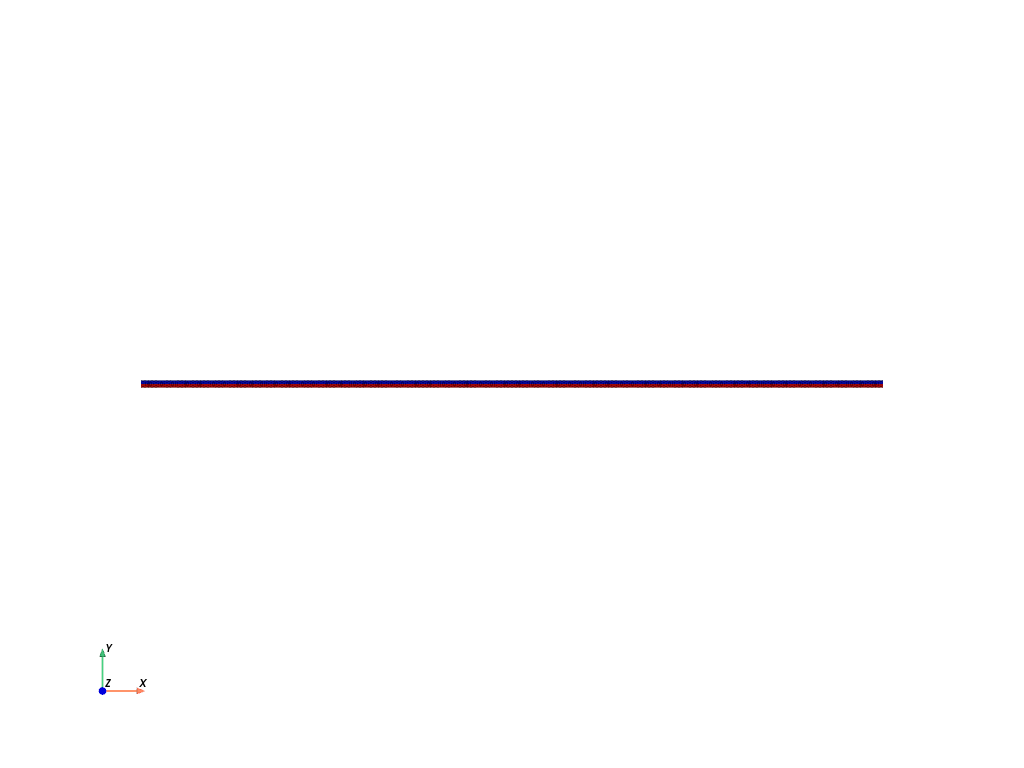

In [29]:
import pyvista
pyvista.set_jupyter_backend('html')
from dolfinx.plot import vtk_mesh
pyvista.start_xvfb()

# initialize a plotter
plotter = pyvista.Plotter()

# Add the mesh.
topology, cell_types, geometry = plot.vtk_mesh(domain, domain.topology.dim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
plotter.add_mesh(grid, show_edges=True, opacity=0.25) 

# Add colored 1D surfaces for the named surfaces
bottom_surf = pyvista.UnstructuredGrid(*vtk_mesh(domain, domain.topology.dim,cell_tags.indices[cell_tags.values==13]) )
top_surf = pyvista.UnstructuredGrid(*vtk_mesh(domain, domain.topology.dim,cell_tags.indices[cell_tags.values==14]) )
#
actor = plotter.add_mesh(bottom_surf, show_edges=False,color="red") # bottom layer is red
actor2 = plotter.add_mesh(top_surf,   show_edges=False,color="blue") #  top  layer is blue


plotter.view_xy()

#labels = dict(zlabel='Z', xlabel='X', ylabel='Y')
labels = dict(xlabel='X', ylabel='Y')
plotter.add_axes(**labels)

    
plotter.screenshot("results/bar_mesh.png")

from IPython.display import Image
Image(filename='results/bar_mesh.png') 

# # Use the following  commands for a  zoom-able  view
# if not pyvista.OFF_SCREEN:
#     plotter.show()
# else:
#     plotter.screenshot("mesh.png")



## Define boundary and volume integration measure

In [30]:
# Define the boundary integration measure "ds" using the facet tags,
# also specify the number of surface quadrature points.
ds = ufl.Measure('ds', domain=domain, subdomain_data=facet_tags, metadata={'quadrature_degree':2})

# Define the volume integration measure "dx" 
# also specify the number of volume quadrature points.
dx = ufl.Measure('dx', domain=domain, metadata={'quadrature_degree': 2})

# Create facet to cell connectivity required to determine boundary facets.
domain.topology.create_connectivity(domain.topology.dim, domain.topology.dim)
domain.topology.create_connectivity(domain.topology.dim, domain.topology.dim-1)
domain.topology.create_connectivity(domain.topology.dim-1, domain.topology.dim)

# #  Define facet normal
n2D = ufl.FacetNormal(domain)
n = ufl.as_vector([n2D[0], n2D[1], 0.0]) # define n as a 3D vector for later use

# Material parameters

In [31]:
# A function for constructing spatially varying (piecewise-constant) material parameters

# Need some extra infrastructure for the spatially-discontinuous material property fields
Vmat = functionspace(domain, ("DG", 0)) # create a DG0 function space on the domain

# Define function ``mat'' for assigning different values for material properties
# for the bottom and top layers
#
def mat(prop_val_bottom, prop_val_top):

    # Define an empty "prop" material parameter function,
    # which lives on the DG0 function space.
    prop = Function(Vmat)
    
    # Now, actualy assign the desired values of the material properies to the new field.
    #
    coords = Vmat.tabulate_dof_coordinates()
    #
    # loop over the coordinates and assign the relevant material property, 
    # based on the local cell tag number.
    for i in range(coords.shape[0]):
        if cell_tags.values[i] == 13:
            prop.vector.setValueLocal(i, prop_val_bottom)
        else:
            prop.vector.setValueLocal(i, prop_val_top)
            
    return prop

In [32]:
k_B      = Constant(domain,PETSc.ScalarType(1.38E-17))             # Boltzmann's constant
theta0   = Constant(domain,PETSc.ScalarType(298))                  # Initial temperature
Gshear_0 = Constant(domain,PETSc.ScalarType(280))                  # Ground sate shear modulus
N_R      = Constant(domain,PETSc.ScalarType(Gshear_0/(k_B*theta0)))# Number polymer chains per unit ref. volume
lambdaL  = Constant(domain,PETSc.ScalarType(5.12))                 # Locking stretch
Kbulk    = Constant(domain,PETSc.ScalarType(1000*Gshear_0))        # Bulk modulus
# alpha  = Constant(domain,PETSc.ScalarType(180.0E-6))           # Coefficient of thermal expansion
alpha    = mat(180.0E-6,0.0)                                       # Coefficient of thermal expansion different in the two layers
c_v      = Constant(domain,PETSc.ScalarType(1839))                 # Specific heat
k_therm  = Constant(domain,PETSc.ScalarType(0.16E3))               # Thermal conductivity

# Simulation time-control related parameters

In [33]:
t    = 0.0       # initialization of time
Ttot = 3600      # total simulation time 
dt   = 60        # Fixed step size

deltaTheta = Constant(domain,PETSc.ScalarType(50))  # temperature increase in degrees K

def thetaRamp(t):
    return theta0 + deltaTheta*t/Ttot

# Function spaces

In [34]:
# Define function space, both vectorial and scalar
# 
U2 = element("Lagrange", domain.basix_cell(), 2, shape=(2,)) # For displacement
P1 = element("Lagrange", domain.basix_cell(), 1)             # For pressure  and temperature                                       
#
TH = mixed_element([U2, P1, P1])  # Taylor-Hood style mixed element
ME = functionspace(domain, TH)    # Total space for all DOFs

# Define actual functions with the required DOFs
w = Function(ME)
u, p, theta = split(w)  # displacement u, pressure p, temperature theta

# A copy of functions to store values in the previous step for time-stepping
w_old = Function(ME)
u_old,  p_old, theta_old = split(w_old)   

# Define test functions    
u_test, p_test,  theta_test = TestFunctions(ME)  

# Define trial functions needed for automatic differentiation
dw = TrialFunction(ME)                   

# Initial conditions

- The initial conditions for $\mathbf{u}$ and $p$ are zero everywhere.
- These are imposed automatically, since we have not specified any non-zero initial conditions.
- We do, however, need to impose the uniform initial condition for temperature $\vartheta = \vartheta_0$. This is done below.

In [35]:
# Assign initial  temperature  theta0 to the body  
w.sub(2).interpolate(lambda x: np.full((x.shape[1],),  theta0))
w_old.sub(2).interpolate(lambda x: np.full((x.shape[1],),  theta0))   

# Subroutines for kinematics and constitutive equations

In [36]:
# Special gradient operators for plane strain 
#
# Gradient of vector field u   
def pe_grad_vector(u):
    
    grad_u = grad(u)
    
    pe_grad_u = ufl.as_tensor([ [grad_u[0,0], grad_u[0,1], 0.0],
                                [grad_u[1,0], grad_u[1,1], 0.0],
                                [        0.0,         0.0, 0.0] ]) 
    
    return pe_grad_u

# Gradient of scalar field y
# (just need an extra zero for dimensions to work out)
def pe_grad_scalar(y):
    
    grad_y = grad(y)
    
    pe_grad_y = ufl.as_vector([grad_y[0], grad_y[1], 0.0])
    
    return pe_grad_y

# Plane strain deformation gradient 
def F_pe_calc(u):
    
    dim = len(u)                # dimension of problem (2)
    
    Id = Identity(dim)          # 2D Identity tensor
    
    F = Id + grad(u)            # 2D Deformation gradient
      
    F_pe =  ufl.as_tensor([ [F[0,0], F[0,1], 0.0],
                            [F[1,0], F[1,1], 0.0],
                            [   0.0,    0.0, 1.0] ]) # Full plane strain F
    
    return F_pe

def lambdaBar_calc(u):
    F = F_pe_calc(u)
    C = F.T*F
    Cdis = J**(-2/3)*C
    I1 = tr(Cdis)
    lambdaBar = sqrt(I1/3.0)
    return lambdaBar

def zeta_calc(u):
    lambdaBar = lambdaBar_calc(u)
    # Use Pade approximation of Langevin inverse
    z    = lambdaBar/lambdaL
    z    = conditional(gt(z,0.95), 0.95, z) # Keep simulation from blowing up
    beta = z*(3.0 - z**2.0)/(1.0 - z**2.0)
    zeta = (lambdaL/(3*lambdaBar))*beta
    return zeta

#----------------------------------------------
# Subroutine for calculating the Piola  stress
#----------------------------------------------
def Piola_calc(u, p, theta):
    F = F_pe_calc(u)
    J = det(F)
    C = F.T*F
    #
    zeta = zeta_calc(u)
    Gshear  = N_R * k_B * theta * zeta
    #
    Piola = J**(-2/3) * Gshear * (F - (1/3)*tr(C)*inv(F.T) ) - J * p * inv(F.T)
    return Piola

#--------------------------------------------------------------
# Subroutine for calculating the stress temperature tensor
#--------------------------------------------------------------
def M_calc(u):
    Id  = Identity(3)         
    F   = F_pe_calc(u) 
    #
    C  = F.T*F
    Cinv = inv(C) 
    J = det(F)
    zeta = zeta_calc(u)
    #
    fac1 = N_R * k_B * zeta
    fac2 = (3*Kbulk*alpha)/J
    #
    M =  J**(-2/3) * fac1 * (Id - (1/3)*tr(C)*Cinv)  - J * fac2 * Cinv
    return M

#--------------------------------------------------------------
# Subroutine for calculating the Heat flux
#--------------------------------------------------------------
def Heat_flux_calc(u, theta):
    F = F_pe_calc(u) 
    J = det(F)         
    #
    Cinv = inv(F.T*F) 
    #
    Tcond = J * k_therm * Cinv # Thermal conductivity tensor
    #
    Qmat = - Tcond * pe_grad_scalar(theta)
    return Qmat

#--------------------------------------------------------------------------------
# Subroutine for calculating the principal Cauchy stress  for visualization only
#--------------------------------------------------------------------------------
def tensor_eigs(T):
    # invariants of T
    I1 = tr(T) 
    I2 = (1/2)*(tr(T)**2 - tr(T*T))
    I3 = det(T)
    
    # Intermediate quantities b, c, d
    b = -I1
    c = I2
    d = -I3
    
    # intermediate quantities E, F, G
    E = (3*c - b*b)/3
    F = (2*(b**3) - 9*b*c + 27*d)/27
    G = (F**2)/4 + (E**3)/27
    
    # Intermediate quantities H, I, J, K, L
    H = sqrt(-(E**3)/27)
    I = H**(1/3)
    J = acos(-F/(2*H))
    K = cos(J/3)
    L = sqrt(3)*sin(J/3)
    
    # Finally, the (not necessarily ordered) eigenvalues
    t1 = 2*I*K - b/3
    t2 = -I*(K+L) - b/3
    t3 = -I*(K-L) - b/3
    
    # Order the eigenvalues using conditionals
    #
    T1_temp = conditional(lt(t1, t3), t3, t1 ) # returns the larger of t1 and t3.
    T1 = conditional(lt(T1_temp, t2), t2, T1_temp ) # returns the larger of T1_temp and t2.
    #
    T3_temp = conditional(gt(t3, t1), t1, t3 ) # returns the smaller of t1 and t3.
    T3 = conditional(gt(T3_temp, t2), t2, T1_temp ) # returns the smaller of T3_temp and t2.
    #
    # use the trace to report the middle eigenvalue.
    T2 = I1 - T1 - T3
    
    return T1, T2, T3


# Evaluate kinematics and constitutive relations

In [37]:
# Kinematics
F = F_pe_calc(u)
J = det(F)   
#
lambdaBar = lambdaBar_calc(u)
#
F_old = F_pe_calc(u_old)
J_old = det(F_old)   
#
C     = F.T*F
C_old = F_old.T*F_old

#  Piola stress
Piola = Piola_calc(u, p, theta)

# Calculate the stress-temperature tensor
M = M_calc(u)

# Calculate the heat flux
Qmat = Heat_flux_calc(u,theta)

# Weak forms

In [38]:
# Residuals:
# Res_0: Balance of forces (test fxn: u)
# Res_1: Coupling pressure (test fxn: p)
# Res_2: Balance of energy  (test fxn: theta)

# Time step field, constant within body
dk = Constant(domain, PETSc.ScalarType(dt))

# The weak form for the equilibrium equation
Res_0 = inner(Piola, pe_grad_vector(u_test) )*dx 

# The weak form for the pressure
fac_p =  ( ln(J) - 3*alpha*(theta-theta0) )/J
#
Res_1 = dot( (p/Kbulk + fac_p), p_test)*dx
      

# The weak form for heat equation
Res_2 = dot( c_v*(theta - theta_old), theta_test)*dx \
        -  (1/2)*theta * inner(M, (C - C_old)) * theta_test*dx \
        -  dk*dot(Qmat , pe_grad_scalar(theta_test) )*dx   
        
# Total weak form
Res = Res_0 +  Res_1 + Res_2 

# Automatic differentiation tangent:
a = derivative(Res, w, dw)

# Set-up output files

In [39]:
# results file name
results_name = "pe_thermoelas_bilayer"

# Function space for projection of results
U1 = element("DG", domain.basix_cell(), 1, shape=(2,)) # For displacement
P0 = element("DG", domain.basix_cell(), 1)             # For  pressure and temperature  
T1 = element("DG", domain.basix_cell(), 1, shape=(3,3))# For stress tensor

V1 = fem.functionspace(domain, P0) # Scalar function space
V2 = fem.functionspace(domain, U1) # Vector function space
V3 = fem.functionspace(domain, T1) # linear tensor function space

# fields to write to output file
u_vis = Function(V2)
u_vis.name = "disp"

p_vis = Function(V1)
p_vis.name = "p"

theta_vis = Function(V1)
theta_vis.name = "theta"

J_vis = Function(V1)
J_vis.name = "J"
J_expr = Expression(J,V1.element.interpolation_points())

lambdaBar_vis = Function(V1)
lambdaBar_vis.name = "lambdaBar"
lambdaBar_expr = Expression(lambdaBar,V1.element.interpolation_points())

P11 = Function(V1)
P11.name = "P11"
P11_expr = Expression(Piola[0,0],V1.element.interpolation_points())
P22 = Function(V1)
P22.name = "P22"
P22_expr = Expression(Piola[1,1],V1.element.interpolation_points())
P33 = Function(V1)
P33.name = "P33"
P33_expr = Expression(Piola[2,2],V1.element.interpolation_points())

T   = Piola*F.T/J
T0   = T - (1/3)*tr(T)*Identity(3)
Mises = sqrt((3/2)*inner(T0, T0))
Mises_vis= Function(V1,name="Mises")
Mises_expr = Expression(Mises,V1.element.interpolation_points())


# set up the output VTX files.
file_results = VTXWriter(
    MPI.COMM_WORLD,
    "results/" + results_name + ".bp",
    [  # put the functions here you wish to write to output
        u_vis, p_vis, theta_vis, J_vis, P11, P22, P33, 
        lambdaBar_vis,Mises_vis,
    ],
    engine="BP4",
)

def writeResults(t):
       # Output field interpolation 
       u_vis.interpolate(w.sub(0))
       p_vis.interpolate(w.sub(1))
       theta_vis.interpolate(w.sub(2))
       J_vis.interpolate(J_expr)
       P11.interpolate(P11_expr)
       P22.interpolate(P22_expr)
       P33.interpolate(P33_expr)
       lambdaBar_vis.interpolate(lambdaBar_expr)
       Mises_vis.interpolate(Mises_expr)

       # Write output fields
       file_results.write(t) 
        

# Infrastructure for pulling out time history data (force, displacement, etc.)

In [40]:
# Identify point for reporting dislacement and temperature
pointForDisp = np.array([L0,H0/2,0.0])

bb_tree = dolfinx.geometry.bb_tree(domain,domain.topology.dim)
cell_candidates = dolfinx.geometry.compute_collisions_points(bb_tree, pointForDisp)
colliding_cells = dolfinx.geometry.compute_colliding_cells(domain, cell_candidates, pointForDisp).array

# Analysis Step

In [41]:
# Give the step a descriptive name
step = "Heat"

## Boundary conditions

In [42]:
# # Markers from gmsh
# - "Left_edge", 8
# - "Bottom_edge", 9 
# - "Right_edge", 10  
# - "Top_edge", 11   
# - "Middle_edge", 12 
# - "Bottom_layer", 13   
# - "Top_layer", 14

# Constant for applied temperature
theta_cons = Constant(domain,PETSc.ScalarType(thetaRamp(0)))

# Find the specific DOFs which will be constrained.
Left_u1_dofs = fem.locate_dofs_topological(ME.sub(0).sub(0), facet_tags.dim, facet_tags.find(8))
#
Bottom_theta_dofs = fem.locate_dofs_topological(ME.sub(2), facet_tags.dim, facet_tags.find(9))
Right_theta_dofs  = fem.locate_dofs_topological(ME.sub(2), facet_tags.dim, facet_tags.find(10))
Top_theta_dofs    = fem.locate_dofs_topological(ME.sub(2), facet_tags.dim, facet_tags.find(11))

# building Dirichlet BCs
bcs_1 = dirichletbc(0.0, Left_u1_dofs, ME.sub(0).sub(0))        # u1 fix Left
#
bcs_2 = dirichletbc(theta_cons, Bottom_theta_dofs, ME.sub(2))   # Temperature - Bottom
bcs_3 = dirichletbc(theta_cons, Right_theta_dofs, ME.sub(2))    # Temperature - Right
bcs_4 = dirichletbc(theta_cons, Top_theta_dofs, ME.sub(2))      # Temperature - Top

# Zero displacement bc for left bottom node
V0, submap = ME.sub(0).collapse()
fixed_u_dofs = fem.locate_dofs_geometrical((ME.sub(0), V0), ground)
fixed_disp = Function(V0)
fixed_disp.interpolate(lambda x: np.stack(( np.zeros(x.shape[1]), np.zeros(x.shape[1]) ) ) )
#
bcs_5 = dirichletbc(fixed_disp, fixed_u_dofs, ME.sub(0))        # u fix -  bottom left node

bcs = [bcs_1, bcs_2, bcs_3, bcs_4, bcs_5]

## Define the nonlinear variational problem

In [43]:
# Set up nonlinear problem
problem = NonlinearProblem(Res, w, bcs, a)

# the global newton solver and params
solver = NewtonSolver(MPI.COMM_WORLD, problem)
solver.convergence_criterion = "incremental"
solver.rtol = 1e-8
solver.atol = 1e-8
solver.max_it = 50
solver.report = True

#  The Krylov solver parameters.
ksp = solver.krylov_solver
opts = PETSc.Options()
option_prefix = ksp.getOptionsPrefix()
opts[f"{option_prefix}ksp_type"] = "preonly" # "preonly" works equally well
opts[f"{option_prefix}pc_type"] = "lu" # do not use 'gamg' pre-conditioner
opts[f"{option_prefix}pc_factor_mat_solver_type"] = "mumps"
opts[f"{option_prefix}ksp_max_it"] = 30
ksp.setFromOptions()

# Initialize arrays for storing output history

In [44]:
# Arrays for storing output history
totSteps = 100000
timeHist0 = np.zeros(shape=[totSteps])
timeHist1 = np.zeros(shape=[totSteps]) 
timeHist2 = np.zeros(shape=[totSteps])
#
timeHist2[0] = theta0 # Initialize the temperature

# Initialize a counter for reporting data
ii=0

# Write initial state to file
writeResults(t=0.0) 

##  Start calculation loop

In [45]:
# Print  message for simulation start
print("------------------------------------")
print("Simulation Start")
print("------------------------------------")
# Store start time 
startTime = datetime.now()

# Time-stepping solution procedure loop
while (round(t + dt, 9) <= Ttot):
     
    # increment time
    t += dt 
    # increment counter
    ii += 1
    
    # update time variables in time-dependent BCs 
    theta_cons.value = float(thetaRamp(t))
    
    # Solve the problem
    try:
        (iter, converged) = solver.solve(w)
    except: # Break the loop if solver fails
        print("Ended Early")
        break
    
    # Collect results from MPI ghost processes
    w.x.scatter_forward()
    
    # Write output to file
    writeResults(t)
    
    # Update DOFs for next step
    w_old.x.array[:] = w.x.array
   
    # Store  displacement and stress at a particular point  at this time
    #
    timeHist0[ii] = t                                                        # time
    #
    timeHist1[ii] = w.sub(0).sub(1).eval([L0,H0/2,0.0],colliding_cells[0])[0] # displacement
    #
    timeHist2[ii] = w.sub(2).eval([L0,H0/2,0.0],colliding_cells[0])[0]        #  temperature

    # Print progress of calculation
    if ii%1 == 0:      
        now = datetime.now()
        current_time = now.strftime("%H:%M:%S")
        print("Step: {} | Increment: {}, Iterations: {}".\
              format(step, ii, iter))
        print("      Simulation Time: {} s  of  {} s".\
              format(round(t,4), Ttot))
        print()  
    

# close the output file.
file_results.close()
         
# End analysis
print("-----------------------------------------")
print("End computation")                 
# Report elapsed real time for the analysis
endTime = datetime.now()
elapseTime = endTime - startTime
print("------------------------------------------")
print("Elapsed real time:  {}".format(elapseTime))
print("------------------------------------------")


------------------------------------
Simulation Start
------------------------------------
Step: Heat | Increment: 1, Iterations: 5
      Simulation Time: 60.0 s  of  3600 s

Step: Heat | Increment: 2, Iterations: 5
      Simulation Time: 120.0 s  of  3600 s

Step: Heat | Increment: 3, Iterations: 5
      Simulation Time: 180.0 s  of  3600 s

Step: Heat | Increment: 4, Iterations: 5
      Simulation Time: 240.0 s  of  3600 s

Step: Heat | Increment: 5, Iterations: 5
      Simulation Time: 300.0 s  of  3600 s

Step: Heat | Increment: 6, Iterations: 5
      Simulation Time: 360.0 s  of  3600 s

Step: Heat | Increment: 7, Iterations: 5
      Simulation Time: 420.0 s  of  3600 s

Step: Heat | Increment: 8, Iterations: 5
      Simulation Time: 480.0 s  of  3600 s

Step: Heat | Increment: 9, Iterations: 5
      Simulation Time: 540.0 s  of  3600 s

Step: Heat | Increment: 10, Iterations: 5
      Simulation Time: 600.0 s  of  3600 s

Step: Heat | Increment: 11, Iterations: 5
      Simulation 

# Plot results

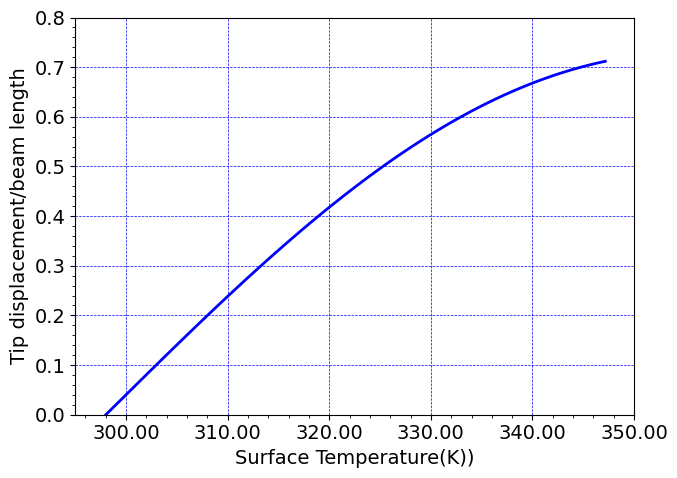

In [46]:
# Set up font size, initialize colors array
font = {'size'   : 14}
plt.rc('font', **font)
#
prop_cycle = plt.rcParams['axes.prop_cycle']
colors     = prop_cycle.by_key()['color']

# Only plot as far as we have time history data
ind = np.argmax(timeHist0[:])

# Create figure for temperature versus  tip-displacement curve.
#
fig = plt.figure() 
ax=fig.gca()  
#---------------------------------------------------------------------------------------------
plt.plot(timeHist2[0:ind], timeHist1[0:ind]/L0, c='b', linewidth=2.0)
#---------------------------------------------------------------------------------------------
plt.xlim(295,350)
plt.ylim(0,0.8)
#
plt.grid(linestyle="--", linewidth=0.5, color='b')
# ax.set_ylabel("Surface temperature change, K",size=14)
ax.set_xlabel("Surface Temperature(K))",size=14)
ax.set_ylabel(r'Tip displacement/beam length',size=14)
#ax.set_title(r'Temperature versus tip displacement curve', size=14, weight='normal')
#
from matplotlib.ticker import AutoMinorLocator,FormatStrFormatter
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
#plt.legend()
import matplotlib.ticker as ticker
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))
# Save figure
fig = plt.gcf()
fig.set_size_inches(7,5)
plt.tight_layout()
plt.savefig("results/pe_bilayer_thermal_actuator.png", dpi=600) 